---
---
---
# **Fake News Classification**
## Max Mager, Teo Fürste, Vladislav Antonov | Prof. Dr. Gruntmüller | Mustererkennung SS25
---
---
---


---
---
---
## **Motivation**
---
---
---

![Alt-Text](./Bilder/FakeGates.png)

<small> 
- Imgur (o. D.): Is it me or does Bill Gates look like he’s at a solid [7] here?, Imgur, [online] https://imgur.com/is-me-does-bill-gates-look-like-hes-solid-7-here-vlMjEgF [abgerufen am 06.06.2025]
- LibGuides: Fake News: Examples (o. D.): [online] https://library-nd.libguides.com/fakenews/examples [abgerufen am 06.06.2025]
</small>

![Alt-Text](./Bilder/FakeProtest.png)

<small>  
- LibGuides: Fake News: Examples (o. D.): [online] https://library-nd.libguides.com/fakenews/examples [abgerufen am 06.06.2025]
- Evon, Dan (2017): FACT CHECK: Black Lives Matter „Thugs“ blocked emergency crews from reaching hurricane victims?, Snopes, [online] https://www.snopes.com/fact-check/black-lives-matter-emergency-crews-hurricane/ [abgerufen am 06.06.2025].
</small>

![Alt-Text](./Bilder/FakePapst.png)

___

<small> 
- Hannah Ritchie, Special to CNBC.com (2016): Read all about it: The biggest fake news stories of 2016, CNBC, [online] https://www.cnbc.com/2016/12/30/read-all-about-it-the-biggest-fake-news-stories-of-2016.html [abgerufen am 06.06.2025]
- LibGuides: Fake News: Examples (o. D.): [online] https://library-nd.libguides.com/fakenews/examples [abgerufen am 06.06.2025] 
</small>

---
---
---
## **Datasets von *Huggingface* und *Kaggle***
---
---
---

| Eigenschaften\Dataset | Fake News Classification             | fake_news       | fake-news-detection-dataset-English | Fake News Detection |
|-----------------------|--------------------------------------|-----------------|-------------------------------------|---------------------|
| Ersteller*in          | Saurabh Shahane                      | Gonzalo Álvarez | Erfan Moosavi Monazzah              | Bhavik Jikadara     |
| Veröffentlicht        | 2021                                 | 2021            | 2023                                | 2024                |
| Einträge gerundet ~   | 72000                                | 41000           | 44000                               | 45000               |
| Zusammenstellung      | Reuters, Kaggle, McIntire, Buzzfeed  | Kaggle, Reuters | Kaggle                              | Unbekannt           |
| Quelle                | [1]                                  | [2]             | [3]                                 | [4]                 |

<small>
- [1] Fake news classification (2023): Kaggle, [online] https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification [abgerufen am 06.06.2025]
- [2] GonzaloA/fake_news · Datasets at Hugging Face (2024): [online] https://huggingface.co/datasets/GonzaloA/fake_news [abgerufen am 06.06.2025]
- [3] ErfanMoosaviMonazzah/fake-news-detection-dataset-English · Datasets at Hugging Face (2024): [online] https://huggingface.co/datasets/ErfanMoosaviMonazzah/fake-news-detection-dataset-English [abgerufen am 06.06.2025]
- [4] Fake news detection (2023): Kaggle, [online] https://www.kaggle.com/datasets/bhavikjikadara/fake-news-detection [abgerufen am 08.06.2025]
</small>

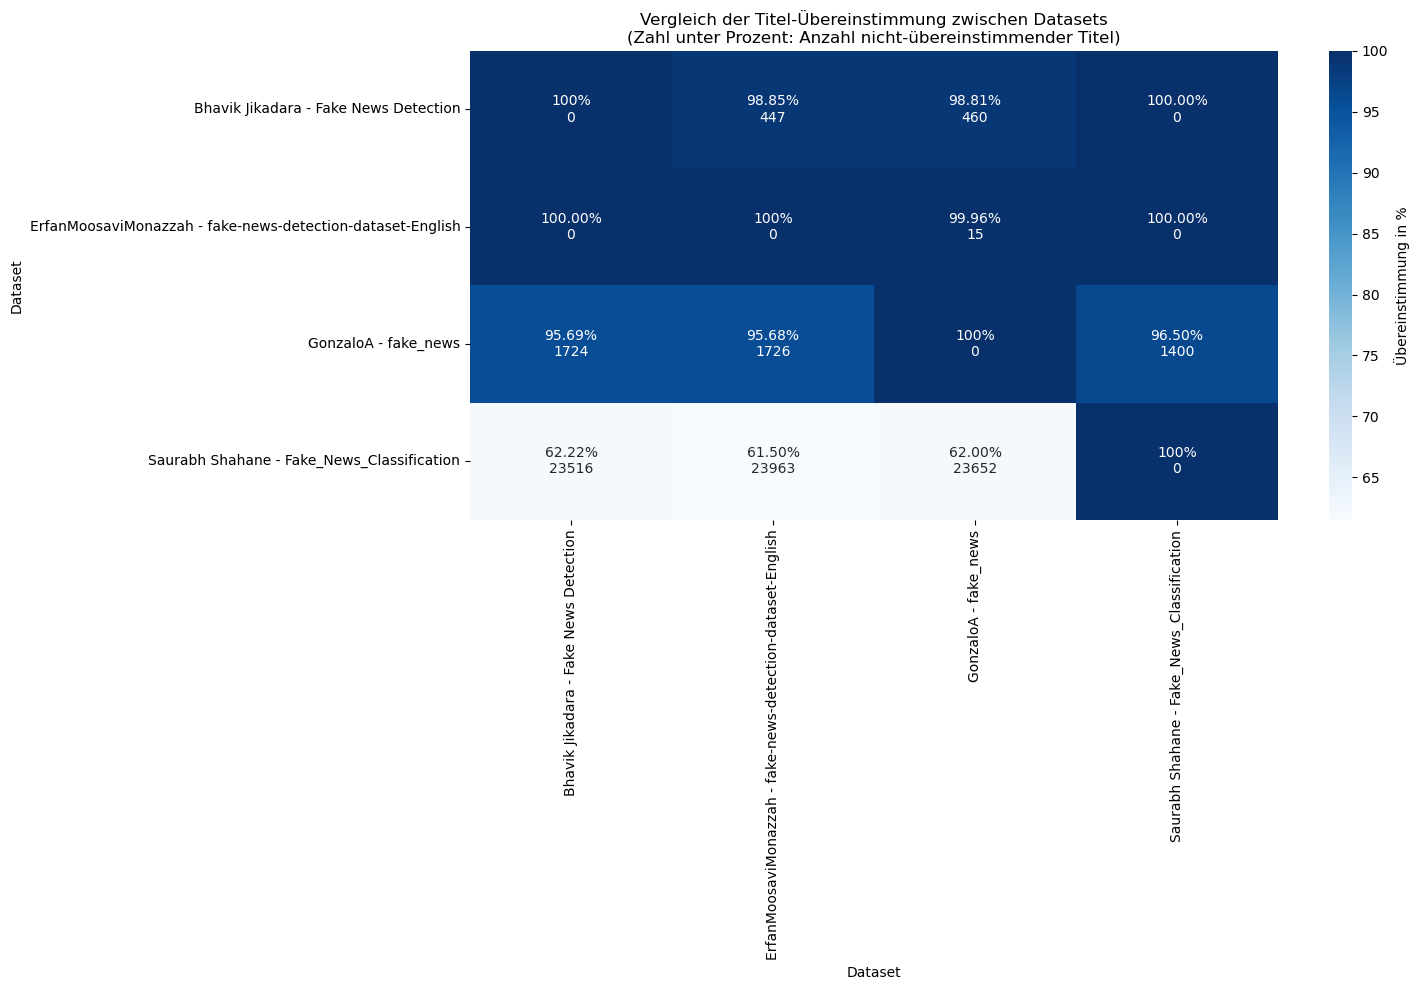

In [51]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

base_path = '../src/data'
datasets = {}

def read_titles(filepath, dataset_name):
    # Sonderbehandlung für den Datensatz "Saurabh Shahane - Fake_News_Classification"
    if dataset_name.lower() == 'saurabh shahane - fake_news_classification':
        try:
            df = pd.read_csv(filepath, sep=',', usecols=['title'], dtype=str)
            return df['title'].dropna().astype(str).str.strip().str.lower().tolist()
        except Exception:
            return []

    # Standardverarbeitung
    for sep in [',', ';', '\t']:
        try:
            df = pd.read_csv(filepath, sep=sep, engine='python', usecols=['title'], dtype=str)
            return df['title'].dropna().astype(str).str.strip().str.lower().tolist()
        except Exception:
            continue
    return []

# Lade alle Datasets ein
folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    all_titles = []
    files = glob.glob(os.path.join(folder_path, '*'))

    for filepath in files:
        titles = read_titles(filepath, folder)
        all_titles.extend(titles)

    unique_titles = set(all_titles)
    datasets[folder] = unique_titles

# Berechne Übereinstimmungsmatrix
result = pd.DataFrame(index=datasets.keys(), columns=datasets.keys(), dtype=float)
dataset_names = list(datasets.keys())

for i, a in enumerate(dataset_names):
    for b in dataset_names[i+1:]:
        titles_a = datasets[a]
        titles_b = datasets[b]

        if len(titles_a) == 0:
            score_ab = 0.0
        else:
            inter_ab = len(titles_a.intersection(titles_b))
            score_ab = (inter_ab / len(titles_a)) * 100

        if len(titles_b) == 0:
            score_ba = 0.0
        else:
            inter_ba = len(titles_b.intersection(titles_a))
            score_ba = (inter_ba / len(titles_b)) * 100

        result.loc[a, b] = score_ab
        result.loc[b, a] = score_ba

for name in dataset_names:
    result.loc[name, name] = 100.0

result = result.round(2)

# Erstelle Annotationen mit Prozent und Anzahl nicht-übereinstimmender Einträge
annot = result.copy().astype(str)

for i, a in enumerate(dataset_names):
    for j, b in enumerate(dataset_names):
        if a == b:
            annot.loc[a, b] = f"100%\n0"
        else:
            titles_a = datasets[a]
            titles_b = datasets[b]
            inter_ab = titles_a.intersection(titles_b)
            unmatched_count = len(titles_a - titles_b)  # Aus Sicht von Dataset a
            percent = result.loc[a, b]
            annot.loc[a, b] = f"{percent:.2f}%\n{unmatched_count}"

# Plot
plt.figure(figsize=(15, 10))
sns.heatmap(result, annot=annot.values, fmt="", cmap='Blues', cbar_kws={'label': 'Übereinstimmung in %'})
plt.title('Vergleich der Titel-Übereinstimmung zwischen Datasets\n(Zahl unter Prozent: Anzahl nicht-übereinstimmender Titel)')
plt.xlabel('Dataset')
plt.ylabel('Dataset')
plt.tight_layout()
plt.show()



---
---
---
## **Max:
Varianten von one-class vergleichen
local outlier factor gewinnt kurz erklären 
hyperparameter Tuning (erklären und kurz zeigen)
Auswertung mit verschiedenen Datensätzen
Vergleich durch benutzung von allen Kombinationen von Datensätzen
auf Modell mit besten Trainingsdaten**
---
---
---


---
---
---
## **Teo TEIL**
---
---
---



---
---
---
## **Vladi:
#Randomforest vorstellen zeigen wie gut es ist
#logistic Regression vorstellen zeigen wie gut es ist
#beide mit hyperparameter Tuning (kann ich noch für dich machen Vladi)**
---
---
---

---
---
---
## **Max:
Auswertung mit verschiedenen Datensätzen
Vergleich durch benutzung von allen Kombinationen von Datensätzen
auf Modell mit besten Trainingsdaten**
---
---
---